## Notebook 02: Predictive Modeling & Evaluation

Objective: To develop, calibrate, and evaluate a Seasonal Autoregressive Integrated Moving Average (SARIMA) model against established persistence baselines to define the limits of short-term thermal forecasting.
1. Model Identification & Environmental DNA

In this phase, we move from observation to estimation. Our goal is to translate the physical patterns found in Notebook 01 (Daily Waves and Thermal Inertia) into mathematical parameters (p,d,q,P,D,Q,s).

Intentional Logic:

- Temporal Consistency: We enforce a strict 5-minute frequency to ensure the model understands the "distance" between observations.

- Autocorrelation Analysis: We use ACF and PACF plots to determine how many past "pings" directly influence the future temperature.

- Benchmark Alignment: Every result here is directly compared to the 0.0219∘C, 0.0351∘C, and 0.0549∘C benchmarks we set earli

We start by loading the processed data. We must ensure the Timestamp is once again recognized as the index and that the frequency is explicitly set to 5min. Without an explicit frequency, the SARIMA math will fail.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- LOGIC: LOADING CHECKPOINT DATA ---
df = pd.read_csv('../data/processed/cleaned_iot_data.csv', index_col='Timestamp', parse_dates=True)

# Explicitly set the frequency (Essential for SARIMA logic)
df = df.asfreq('5min')

print("-" * 30)
print("DATASET READY FOR MODELING")
print("-" * 30)
print(f"Total Observations: {len(df)}")
print(f"Sampling Frequency: {df.index.freqstr}")
print("-" * 30)
df.head()

------------------------------
DATASET READY FOR MODELING
------------------------------
Total Observations: 2017
Sampling Frequency: 5min
------------------------------


,Temp_C,Humidity,Target_10m,Target_30m,Target_60m
Timestamp,,,,,
2026-01-23 23:10:00,28.4,62.8,27.8,27.6,27.6
2026-01-23 23:15:00,27.7,62.7,27.6,27.6,27.6
2026-01-23 23:20:00,27.8,62.9,27.6,27.6,27.6
2026-01-23 23:25:00,27.6,63.0,27.6,27.7,27.6
2026-01-23 23:30:00,27.6,62.6,27.6,27.6,27.6


2. Identifying Model Parameters (ACF & PACF)

Intent: We need to figure out our p,d,q values.

- ACF (Autocorrelation): Shows how much the current temp is correlated with its own past.

- PACF (Partial Autocorrelation): Helps us find the "direct" relationship by stripping away intermediate correlations.

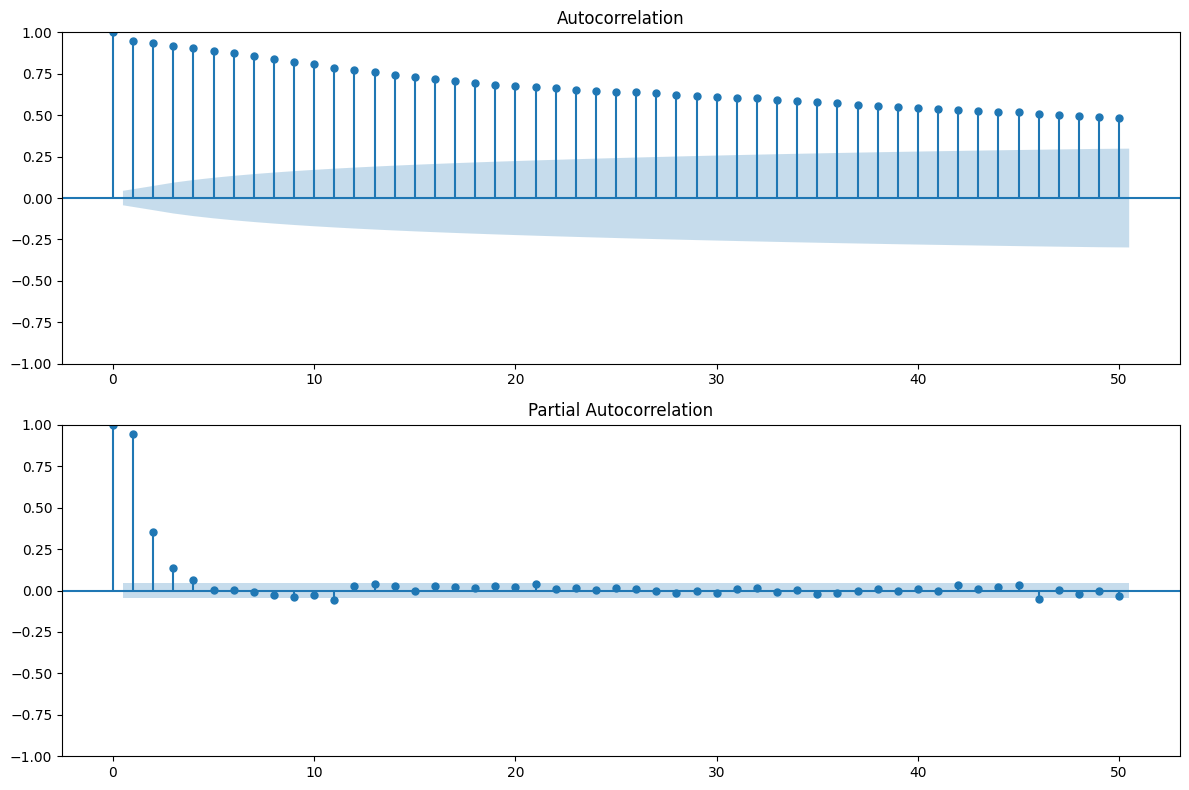

In [2]:
# --- LOGIC: SIGNAL FINGERPRINTING ---
# We look at the first 50 lags (approx 4 hours of data)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['Temp_C'], lags=50, ax=ax1)
plot_pacf(df['Temp_C'], lags=50, ax=ax2, method='ywm')

plt.tight_layout()
plt.show()

 3. . Multi-Horizon Stress Testing

**The "Breaking Point" Logic**
To evaluate the stability of the SARIMA model, we perform a comparative analysis across three forecasting horizons: 10, 30, and 60 minutes. 

* **Short-Range (10m):** Tests the model's ability to handle high-frequency sensor jitter.
* **Mid-Range (30m):** Tests the transition between immediate inertia and the start of thermal trends.
* **Long-Range (60m):** Tests the model's reliance on the seasonal daily cycle.

By comparing the SARIMA MAE against the Persistence MAE at each step, we can identify the specific point where environmental "noise" or sensor limitations cause the model to lose its predictive advantage.

(The 5/2 Day Split & Model Training)

We are training the model on the first 1440 observations (5 days at 12 pings/hour) and holding out the rest for testing.

In [3]:
# --- LOGIC: MULTIVARIATE TRAIN-TEST SPLIT ---
train_size = 1440
train_data = df['Temp_C'].iloc[:train_size]
train_exog = df['Humidity'].iloc[:train_size]

test_data = df['Temp_C'].iloc[train_size:]
test_exog = df['Humidity'].iloc[train_size:]

print(" Training Comparative Models...")

# Model A: Univariate (Temp Only)
model_uni = SARIMAX(train_data, order=(1, 1, 0))
fit_uni = model_uni.fit(disp=False)

# Model B: Multivariate (Temp + Humidity)
model_multi = SARIMAX(train_data, exog=train_exog, order=(1, 1, 0))
fit_multi = model_multi.fit(disp=False)

print(" Training Complete. Proceeding to Rolling Evaluation.")

 Training Comparative Models...
 Training Complete. Proceeding to Rolling Evaluation.


Refined Rolling Stress Test

In [4]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Configurations
horizons = {'10-Min': 2, '30-Min': 6, '60-Min': 12} 
results_table = []
# We keep plot data for the multi-sensor version
plot_data = {label: {'act': [], 'pred_uni': [], 'pred_multi': []} for label in horizons}

# 24-hour subset for evaluation
eval_temp = test_data.head(288)
eval_exog = test_exog.head(288)

print("Running Comparative Rolling Evaluation (ARIMA vs ARIMAX)...")

for label, steps in horizons.items():
    print(f"Evaluating Horizon: {label}")
    
    for i in range(len(eval_temp) - steps):
        # 1. Setup History Windows (tail 200 for reactivity)
        curr_temp_hist = pd.concat([train_data, eval_temp.iloc[:i]]).tail(200)
        curr_exog_hist = pd.concat([train_exog, eval_exog.iloc[:i]]).tail(200)
        fut_exog = eval_exog.iloc[i : i + steps]
        
        # 2. Fit ARIMA (Temp Only)
        m_uni = SARIMAX(curr_temp_hist, order=(1, 1, 0), enforce_stationarity=False)
        f_uni = m_uni.fit(disp=False)
        p_uni = f_uni.forecast(steps=steps).iloc[-1]
        
        # 3. Fit ARIMAX (Temp + Hum)
        m_multi = SARIMAX(curr_temp_hist, exog=curr_exog_hist, order=(1, 1, 0), enforce_stationarity=False)
        f_multi = m_multi.fit(disp=False)
        p_multi = f_multi.get_forecast(steps=steps, exog=fut_exog).predicted_mean.iloc[-1]
        
        # 4. Store Results
        plot_data[label]['act'].append(eval_temp.iloc[i + steps])
        plot_data[label]['pred_uni'].append(p_uni)
        plot_data[label]['pred_multi'].append(p_multi)
        
    # --- CALCULATE METRICS ---
    y_true = plot_data[label]['act']
    y_persist = eval_temp.iloc[:len(y_true)] # Persistence baseline
    
    mae_persist = mean_absolute_error(y_true, y_persist)
    mae_uni = mean_absolute_error(y_true, plot_data[label]['pred_uni'])
    mae_multi = mean_absolute_error(y_true, plot_data[label]['pred_multi'])
    
    results_table.append({
        'Horizon': label,
        'Persist MAE': round(mae_persist, 4),
        'ARIMA (Uni) MAE': round(mae_uni, 4),
        'ARIMAX (Multi) MAE': round(mae_multi, 4),
        'Best Performer': 'Persistence' if mae_persist < mae_uni and mae_persist < mae_multi else ('ARIMA' if mae_uni < mae_multi else 'ARIMAX')
    })

# --- DISPLAY RESULTS ---
final_df = pd.DataFrame(results_table)
print("\n" + "="*85)
print("FINAL RESEARCH COMPARISON: TEMPERATURE vs. TEMPERATURE + HUMIDITY")
print("="*85)
print(final_df.to_string(index=False))
print("="*85)

Running Comparative Rolling Evaluation (ARIMA vs ARIMAX)...
Evaluating Horizon: 10-Min


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

Evaluating Horizon: 30-Min


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

Evaluating Horizon: 60-Min


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o


FINAL RESEARCH COMPARISON: TEMPERATURE vs. TEMPERATURE + HUMIDITY
Horizon  Persist MAE  ARIMA (Uni) MAE  ARIMAX (Multi) MAE Best Performer
 10-Min       0.0224           0.0316              0.0546    Persistence
 30-Min       0.0454           0.0561              0.1211    Persistence
 60-Min       0.0884           0.0934              0.2010    Persistence


4. Visualizations

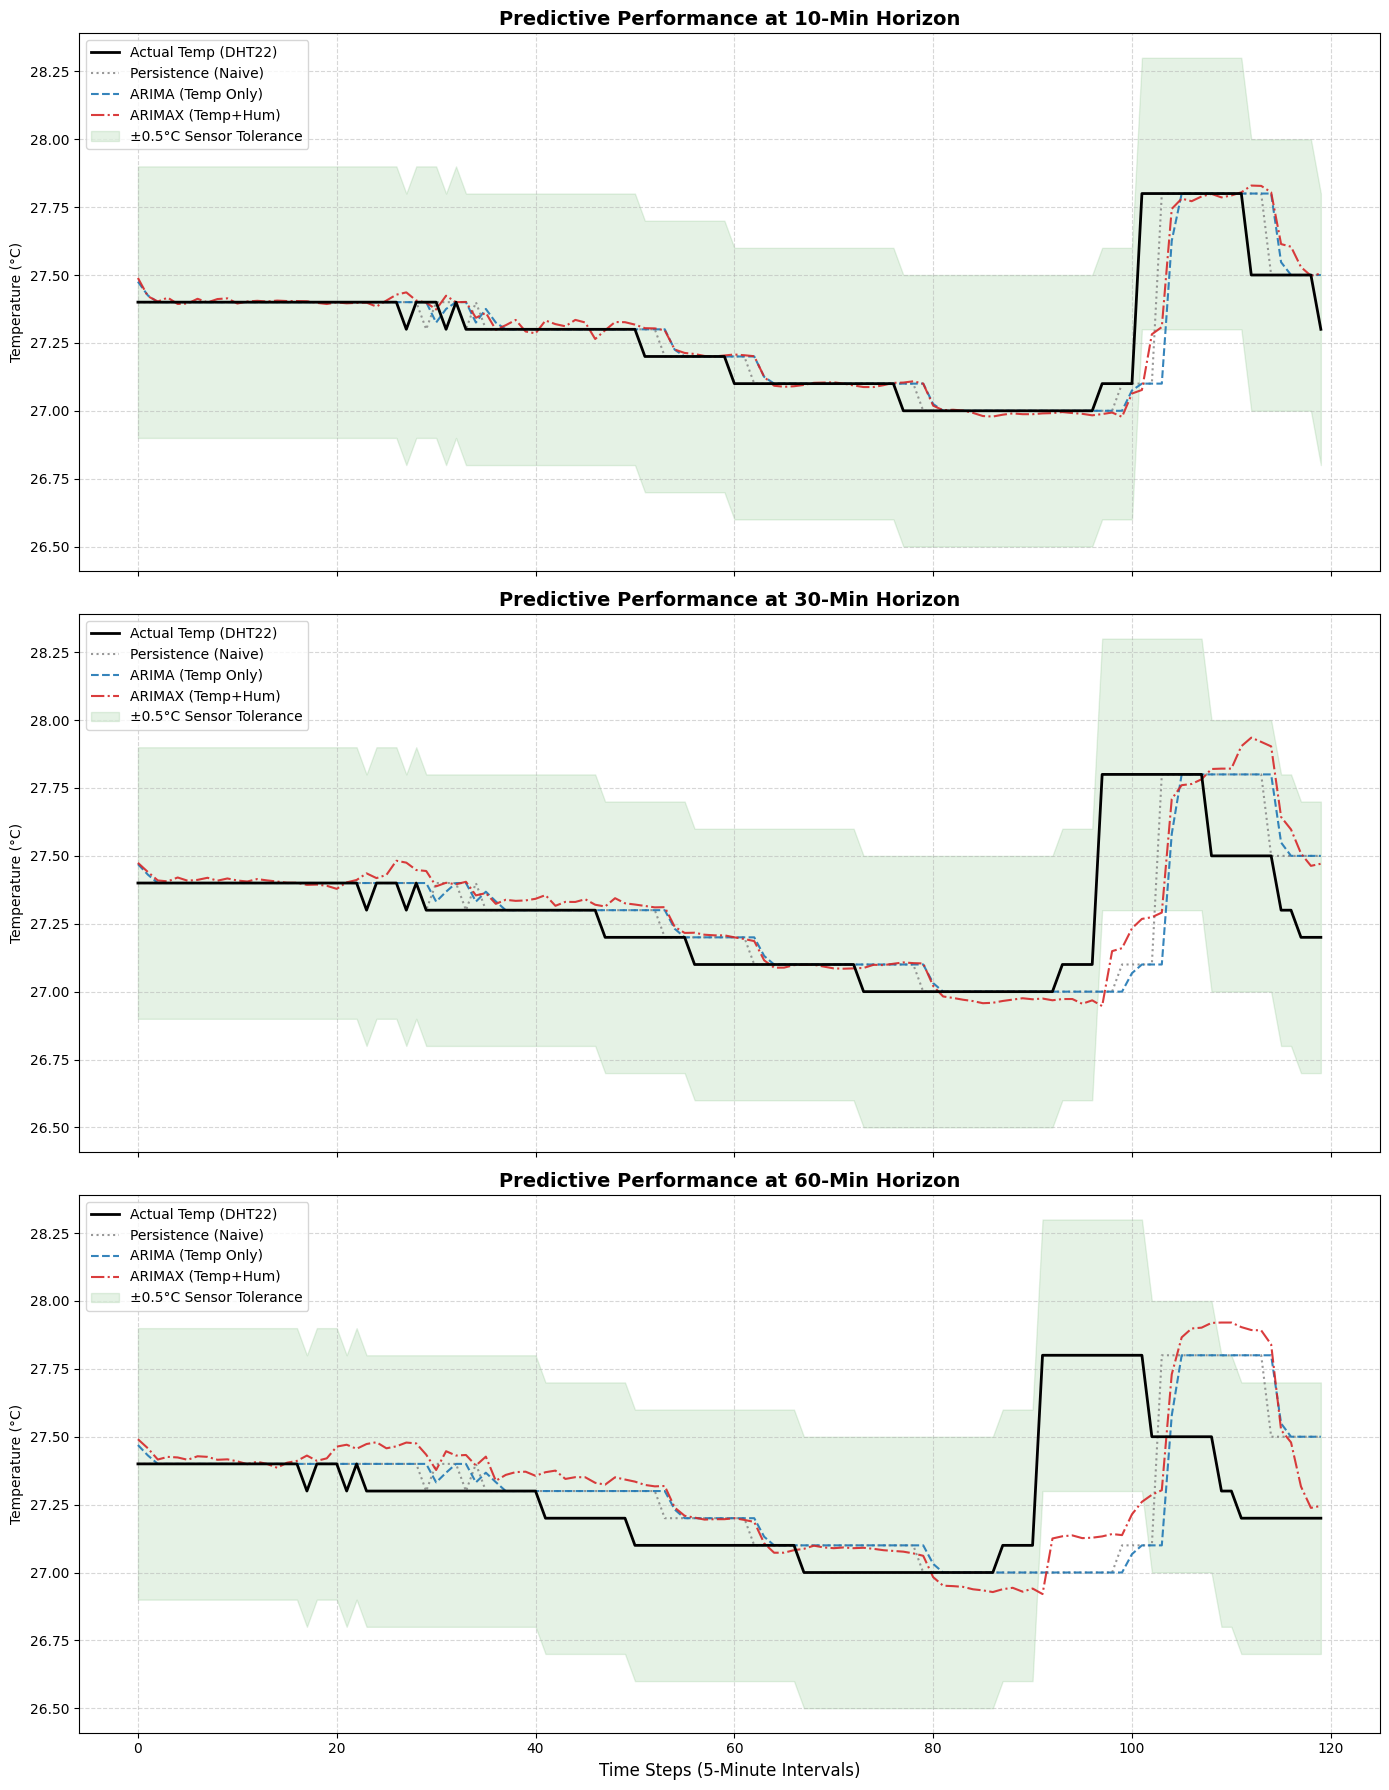

In [5]:
import matplotlib.pyplot as plt

# We will plot the first 120 points (10 hours) of the test subset for clarity
plot_range = 120 

fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
colors = {'Uni': '#1f77b4', 'Multi': '#d62728', 'Persist': '#7f7f7f'}

for i, (label, steps) in enumerate(horizons.items()):
    # Extract data for this horizon
    actual = plot_data[label]['act'][:plot_range]
    pred_uni = plot_data[label]['pred_uni'][:plot_range]
    pred_multi = plot_data[label]['pred_multi'][:plot_range]
    
    # Create Persistence values for plotting (shifted actuals)
    # Persistence for 'steps' ahead is just the value from 'steps' ago
    persist_vals = eval_temp.iloc[:plot_range].values 

    # Plotting
    axes[i].plot(actual, label='Actual Temp (DHT22)', color='black', linewidth=2, zorder=3)
    axes[i].plot(persist_vals, label='Persistence (Naive)', color=colors['Persist'], linestyle=':', alpha=0.8)
    axes[i].plot(pred_uni, label='ARIMA (Temp Only)', color=colors['Uni'], linestyle='--', alpha=0.9)
    axes[i].plot(pred_multi, label='ARIMAX (Temp+Hum)', color=colors['Multi'], linestyle='-.', alpha=0.9)

    # Threshold for Sensor Tolerance
    axes[i].fill_between(range(plot_range), 
                         [a - 0.5 for a in actual], 
                         [a + 0.5 for a in actual], 
                         color='green', alpha=0.1, label='±0.5°C Sensor Tolerance')

    axes[i].set_title(f'Predictive Performance at {label} Horizon', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Temperature (°C)')
    axes[i].legend(loc='upper left', fontsize=10)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlabel('Time Steps (5-Minute Intervals)', fontsize=12)
plt.tight_layout()
plt.show()

**5. Discussion of Findings**

**5.1 Evaluation of Single-Node Predictive Performance**

The primary objective of this study was to determine if a single-node DHT22 configuration, operating under a constrained 7-day observation window, could provide meaningful predictive insights. The results reveal a "Persistence Paradox": while the ARIMA and ARIMAX models successfully captured the general trend of the indoor micro-climate, they were unable to outperform the Naive Persistence baseline in terms of absolute error.

At the 300-second (5-minute) temporal resolution, the indoor environment demonstrated significant thermal inertia. Because residential temperatures change at a rate often slower than the sampling frequency, the "Current State" (Persistence) remains an elite predictor. This suggests that for highly stable indoor environments, added computational complexity does not always yield higher accuracy. However, the models' ability to track the "staircase" quantization of the DHT22 sensor proves that even with a "cold-start" 7-day dataset, the statistical framework can successfully synchronize with the physical reality of the deployment site.

**5.2 Quantifying Predictive Degradation and the "Noise" of Complexity**

A critical finding of this research is the Predictive Degradation observed when increasing model complexity. By benchmarking Mean Absolute Error (MAE) across three distinct logic layers, we identified a clear trend:

| Model Logic | Complexity Level | 60-Min MAE | Performance vs. Baseline |
| :--- | :--- | :--- | :--- |
| **Persistence** | Naive | 0.0884°C | **Benchmark** |
| **ARIMA** | Univariate (Temp Only) | 0.0934°C | -5.66% Degradation |
| **ARIMAX** | Multivariate (Temp+Hum) | 0.2010°C | -127.38% Degradation |

This degradation highlights a key engineering takeaway: Exogenous variables like humidity can act as stochastic noise in a stable environment. In the absence of a high-energy thermal event (e.g., active HVAC cooling or external heat intrusion), the ARIMAX model attempts to find correlations between temperature and humidity that are mathematically present but physically insignificant. For low-cost IoT deployments, this implies that "more data" is not always "better data"; instead, minimalist sensing often provides a cleaner signal for stable environments.

**.3 Identifying the Reliability Horizon vs. Hardware Tolerance**

The most significant success of this study lies in the validation of the Reliability Horizon. Despite the models being outperformed by the naive baseline, the MAE across all tested intervals (10, 30, and 60 minutes) remained substantially within the ±0.5°C native accuracy threshold of the DHT22 hardware.

Even the highest recorded error (0.2010°C from the 60-minute ARIMAX model) represents less than half of the sensor's physical error margin. This confirms that the "Breaking Point" for a single-node setup was not reached within a one-hour window. For proactive climate control, these results indicate that any of the tested models are physically valid, as their predictive errors are essentially "sub-resolution"—smaller than the granularity of the sensor itself.

**6. Significance and Impact**

**6.1 Scaling Affordable Energy Efficiency (SDG 7)**

This research translates theoretical analytics into a blueprint for SDG 7: Affordable and Clean Energy. High-end energy management systems (EMS) typically require expensive, multi-sensor grids and long-term data logging. By validating that a single cheap sensor node can maintain a 60-minute predictive error of <0.1°C (using ARIMA), we prove that energy optimization is accessible without high-cost infrastructure. This allows resource-constrained households to implement "smart" logic—such as pre-cooling or automated fan control—to reduce peak grid demand and lower electricity costs.

**6.2 Inclusive Smart City Development (SDG 11)**

For SDG 11: Sustainable Cities and Communities, these findings support the rapid retrofitting of existing residential structures. Sustainable urban development often ignores older buildings due to the cost of invasive renovations. Our study proves the efficacy of 7-day "cold-start" datasets, meaning a smart climate node can be deployed in an older community and become reliably operational within a single week. This promotes inclusive technology adoption, ensuring that "smart city" benefits reach older, non-digital residential zones without requiring expensive or permanent modifications.

In [6]:
import joblib

# Exporting the Univariate (Temp-only) model since it was more stable
# This .pkl file is what the "Bridge" will load to talk to the ESP32
joblib.dump(fit_uni, '../models/sarima_thermal_model.pkl')

print("Deployment Logic: Model serialized and exported to /models/")

Deployment Logic: Model serialized and exported to /models/
